In [2]:
## dataset
#import tensorflow.keras as keras
## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import initializers


from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from numpy.random import RandomState
from itertools import chain
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from skbio.stats.distance import mantel
from os import listdir
import seaborn as sns

In [35]:
def getWeightDir(omic, metric, layer2, direct_filter, gene_prev_filter):
    #Name file    
    if direct_filter:
        weight_dir =  'weights/'+ omic + "/" + "direct_filter/"
    else:
        weight_dir =  'weights/'+ omic + "/" + "no_filter/"
    weight_dir = weight_dir + "prev_filt" + str(gene_prev_filter) + "/"
    if layer2:
        weight_dir = weight_dir + "layer2/"
    else:
        weight_dir = weight_dir + "layer1/"
    weight_dir = weight_dir + metric + "/"
    print(weight_dir)
    return(weight_dir)

def getFileName(weight_dir, dim):
    best_val_scores = []
    weight_dir_tmp = weight_dir + dim + "dim/"
    weight_files = listdir(weight_dir_tmp)

    #pick best val score in that folder
    val_scores = [float(i.split('val')[1][0:5]) for i in weight_files]
    best_val_score = np.min(val_scores)
    file_name = weight_files[np.argmin(val_scores)]
    return(weight_dir_tmp + file_name)

def getModel(file_name, metric):
    model = load_model(file_name, compile = False)
    if metric == "euclidean":
        model.compile(loss = 'mean_squared_logarithmic_error')
    if metric == "braycurtis":
        model.compile(loss = brayCurtisLoss)
    if metric == "manhattan":
        model.compile(loss = 'mean_absolute_error')
    return(model)

def getXData(gene_prev_filter, omic):
    x_train = pd.read_csv('data/' + omic + 'x_train.csv', index_col = 0)
    x_val = pd.read_csv('data/' + omic + 'x_val.csv', index_col = 0)
    x_test = pd.read_csv('data/' + omic + 'x_test.csv', index_col = 0)

    #filter gene data
    x_tmp = pd.concat([x_train, x_val, x_test], )
    x_tmp = x_tmp.loc[:, (x_tmp == 0).sum() < (x_tmp.shape[0] * gene_prev_filter)]
    x_train = x_tmp.loc[x_train.index.values, :]
    x_val = x_tmp.loc[x_val.index.values, :]
    x_test = x_tmp.loc[x_test.index.values, :]

    x_train = x_train + 1
    x_val = x_val + 1
    x_test = x_test + 1
    print("Number of features MTG: " + str(x_train.shape[1]))
    return(x_train, x_val, x_test)

def filterForProkaryotes(mbx_tab):
    print(mbx_tab.shape)
    metabolites_not_in_db = pd.read_csv('../../data/metabol/metabolites_not_in_database.csv', index_col = 0)
    metabolites_in_db_directly = mbx_tab.columns.values[[i not in metabolites_not_in_db.index.values for i in mbx_tab.columns.values]]
    keep1 = metabolites_not_in_db.IN_MICROBIAL_DATABASE != 'FALSE'
    keep3 = metabolites_not_in_db.IN_MICROBIAL_DATABASE != 'FALSE; not in pubchem'
    keep4 = metabolites_not_in_db.IN_MICROBIAL_DATABASE != 'FALSE, not in pubchem'
    keep2 = [i == i for i in metabolites_not_in_db.IN_MICROBIAL_DATABASE] #check for NaN
    keep = [i and j and k and l for i,j,k,l in zip(keep1.values, keep2, keep3.values, keep4.values)]
    metabolites_in_db_indirectly = metabolites_not_in_db.loc[keep, :].index.values
    metabolites_keep = np.concatenate((metabolites_in_db_directly, metabolites_in_db_indirectly))
    #print(len(metabolites_in_db_directly))
    #print(len(metabolites_in_db_indirectly))
    return(mbx_tab[metabolites_keep])

def getYData(direct_filter, omic):
    #load data
    y_train = pd.read_csv('data/' + omic + 'y_train.csv', index_col = 0)
    y_val = pd.read_csv('data/' + omic + 'y_val.csv', index_col = 0)
    y_test = pd.read_csv('data/' + omic + 'y_test.csv', index_col = 0)
    if direct_filter == True:
        y_train = filterForProkaryotes(y_train)
        y_val = filterForProkaryotes(y_val)
        y_test = filterForProkaryotes(y_test)
    print("Number of features MBX: ", str(y_train.shape[1]))
    return(y_train, y_val, y_test)

def getMetaboliteCorrelations(x, y, weight_dir, dims):
    metabolite_corr = []
    mantel_corr = []
    sample_dist_measured = squareform(pdist(np.array(y), metric = "braycurtis"))
    y = y / np.max(np.max(y))
    for dim in dims:
        file_name = getFileName(weight_dir, dim)
        model = getModel(file_name, metric)
        preds = model.predict(x)
        preds = preds / np.max(np.max(preds))
        #metabolite correlations
        rs = []
        for i in np.arange(0, y.shape[1]):
            corr_res = pearsonr(preds[:, i], y.iloc[:, i])
            rs = rs  + [corr_res[0]]
        metabolite_corr = metabolite_corr + [np.nanmean(rs)]
        
        #mantel test
        sample_dist_preds = squareform(pdist(preds, metric = "braycurtis"))
        try:
            mantel_res = mantel(sample_dist_preds, sample_dist_measured)[0]
        except:
            mantel_res = float("NaN")
        mantel_corr = mantel_corr + [mantel_res]

    return(metabolite_corr, mantel_corr)


def brayCurtisLoss(y_true, y_pred):
    return(K.abs(K.sum(y_true - y_pred)) / K.sum(y_true + y_pred))

In [36]:
#Find the best set of hyperparameters
def getCorrelationOverParameters(omic, prev_filters):
    direct_filters = [True, False]
    metrics = ['manhattan', 'euclidean', 'braycurtis']
    layers = [True, False]
    dims = ['10', '25', '50', '100', '200', '500']
    
    correlations_df = pd.DataFrame()
    mantel_df = pd.DataFrame()
    for prev_filter in prev_filters:
        for direct_filter in direct_filters:
            for metric in metrics:
                for layer2 in layers:
                    weight_dir = getWeightDir(omic, metric, layer2, direct_filter, prev_filter)
                    x_train, x_val, x_test = getXData(prev_filter, omic)
                    y_train, y_val, y_test = getYData(direct_filter, omic)
                    
                    #Metabolite spearman correlations
                    #metabolite_corr_train = getMetaboliteCorrelations(x_train, y_train, weight_dir, dims)
                    metabolite_corr_val, mantel_corr = getMetaboliteCorrelations(x_val, y_val, weight_dir, dims)
                    #metabolite_corr_test = getMetaboliteCorrelations(x_test, y_test, weight_dir, dims)
                    

                    
                    s = str(prev_filter) + "_" + str(direct_filter) + "_" + str(metric) + "_" + str(layer2)
                    correlations_df[s] = metabolite_corr_val
                    mantel_df[s] = mantel_corr

    correlations_df['dims'] = dims
    correlations_df.set_index('dims')
    mantel_df['dims'] = dims
    mantel_df.set_index('dims')
    return(correlations_df, mantel_df)




In [37]:
omic = "16s_metabol/"
s_corr_df, s_mantel_df = getCorrelationOverParameters(omic = omic, prev_filters = [0.1, 0.5, 0.8, 1.0])
s_corr_df = s_corr_df.drop('dims', axis = 1)
s_mantel_df = s_mantel_df.drop('dims', axis = 1)

weights/16s_metabol//direct_filter/prev_filt0.1/layer2/manhattan/
Number of features MTG: 18
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


weights/16s_metabol//direct_filter/prev_filt0.1/layer1/manhattan/
Number of features MTG: 18
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//direct_filter/prev_filt0.1/layer2/euclidean/
Number of features MTG: 18
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//direct_filter/prev_filt0.1/layer1/euclidean/
Number of features MTG: 18
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//direct_filter/prev_filt0.1/layer2/braycurtis/
Number of features MTG: 18
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//direct_filter/prev_filt0.1/layer1/braycurtis/
Number of features MTG: 18
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//no_filter/prev_filt0.1/layer2/manhattan/
Number of features MTG: 18
Number of features MBX:  1267
weights/16s_metabol//no_filter/prev_filt0.1/layer1/manhattan/
Number of features MTG: 18
Number of featu

c:\users\ctata\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


weights/16s_metabol//direct_filter/prev_filt0.5/layer2/euclidean/
Number of features MTG: 111
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//direct_filter/prev_filt0.5/layer1/euclidean/
Number of features MTG: 111
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//direct_filter/prev_filt0.5/layer2/braycurtis/
Number of features MTG: 111
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//direct_filter/prev_filt0.5/layer1/braycurtis/
Number of features MTG: 111
(44, 1267)
(15, 1267)
(15, 1267)
Number of features MBX:  291
weights/16s_metabol//no_filter/prev_filt0.5/layer2/manhattan/
Number of features MTG: 111
Number of features MBX:  1267
weights/16s_metabol//no_filter/prev_filt0.5/layer1/manhattan/
Number of features MTG: 111
Number of features MBX:  1267
weights/16s_metabol//no_filter/prev_filt0.5/layer2/euclidean/
Number of features MTG: 111
Number of features MBX:  1267
weights/16s_me

c:\users\ctata\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


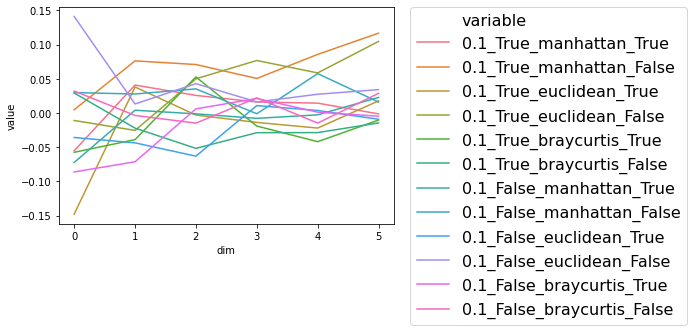

In [50]:
s_corr_df['dim'] = s_corr_df.index.values
tmp = ['0.1' in i for i in s_corr_df.columns.values]
df = s_corr_df.loc[:, tmp]
df['dim'] = s_corr_df.dim
sns.lineplot(x = "dim", y = "value", hue = "variable", data = df.melt('dim'))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '16')

In [33]:
omic = "mtg_metabol/"
mtg_corr_df, mtg_mantel_df = getCorrelationOverParameters(omic = omic, prev_filters = [0.1, 0.5, 0.8])
mtg_corr_df = mtg_corr_df.drop('dims', axis = 1)
mtg_mantel_df = mtg_mantel_df.drop('dims', axis = 1)

weights/mtg_metabol//direct_filter/prev_filt0.1/layer2/manhattan/
Number of features MTG: 3393
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


weights/mtg_metabol//direct_filter/prev_filt0.1/layer1/manhattan/
Number of features MTG: 3393
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_filt0.1/layer2/euclidean/
Number of features MTG: 3393
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_filt0.1/layer1/euclidean/
Number of features MTG: 3393
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_filt0.1/layer2/braycurtis/
Number of features MTG: 3393
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_filt0.1/layer1/braycurtis/
Number of features MTG: 3393
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//no_filter/prev_filt0.1/layer2/manhattan/
Number of features MTG: 3393
Number of features MBX:  1267
weights/mtg_metabol//no_filter/prev_filt0.1/layer1/manhattan/
Number of features MTG: 3393
N

c:\users\ctata\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


weights/mtg_metabol//no_filter/prev_filt0.1/layer2/euclidean/
Number of features MTG: 3393
Number of features MBX:  1267
weights/mtg_metabol//no_filter/prev_filt0.1/layer1/euclidean/
Number of features MTG: 3393
Number of features MBX:  1267
weights/mtg_metabol//no_filter/prev_filt0.1/layer2/braycurtis/
Number of features MTG: 3393
Number of features MBX:  1267
weights/mtg_metabol//no_filter/prev_filt0.1/layer1/braycurtis/
Number of features MTG: 3393
Number of features MBX:  1267
weights/mtg_metabol//direct_filter/prev_filt0.5/layer2/manhattan/
Number of features MTG: 4718
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_filt0.5/layer1/manhattan/
Number of features MTG: 4718
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_filt0.5/layer2/euclidean/
Number of features MTG: 4718
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_fil

In [210]:
omic = "mtt_metabol/"
mtt_corr_df, mtt_mantel_df = getCorrelationOverParameters(omic = omic, prev_filters = [0.1, 0.5, 0.8])
mtt_corr_df = mtt_corr_df.drop('dims', axis = 1)
mtt_mantel_df = mtt_mantel_df.drop('dims', axis = 1)

weights/mtt_metabol//direct_filter/prev_filt0.1/layer2/manhattan/
Number of features MTG: 2664
(56, 1267)
(20, 1267)
(20, 1267)
Number of features MBX:  291
weights/mtt_metabol//direct_filter/prev_filt0.1/layer1/manhattan/
Number of features MTG: 2664
(56, 1267)
(20, 1267)
(20, 1267)
Number of features MBX:  291
weights/mtt_metabol//direct_filter/prev_filt0.1/layer2/euclidean/
Number of features MTG: 2664
(56, 1267)
(20, 1267)
(20, 1267)
Number of features MBX:  291
weights/mtt_metabol//direct_filter/prev_filt0.1/layer1/euclidean/
Number of features MTG: 2664
(56, 1267)
(20, 1267)
(20, 1267)
Number of features MBX:  291
weights/mtt_metabol//direct_filter/prev_filt0.1/layer2/braycurtis/
Number of features MTG: 2664
(56, 1267)
(20, 1267)
(20, 1267)
Number of features MBX:  291
weights/mtt_metabol//direct_filter/prev_filt0.1/layer1/braycurtis/
Number of features MTG: 2664
(56, 1267)
(20, 1267)
(20, 1267)
Number of features MBX:  291
weights/mtt_metabol//no_filter/prev_filt0.1/layer2/manha

In [211]:
corr_mat = s_corr_df.values
flat = corr_mat.flatten()
flat.sort()
val = flat[::-1][3]
print(val)

corr_mat = mtg_corr_df.values
flat = corr_mat.flatten()
flat.sort()
val = flat[::-1][3]
print(val)

corr_mat = mtt_corr_df.values
flat = corr_mat.flatten()
flat.sort()
val = flat[::-1][3]
print(val)

0.06647303074162038
0.30364371210080554
0.18178767668530613


In [34]:
corr_mat = mtg_corr_df.values
flat = corr_mat.flatten()
flat.sort()
val = flat[::-1][3]
print(val)

tmp = np.where(corr_mat == val)
x = tmp[0][0]
y = tmp[1][0]
print(x)
print(y)

print(mtg_corr_df.columns.values[y])
mtg_corr_df.iloc[:, y-1:y+1]

0.21970049277058595
1
24
0.8_True_manhattan_True


,0.5_False_braycurtis_False,0.8_True_manhattan_True
0,0.091983,0.169738
1,-0.015261,0.219700
2,0.015325,0.116713
3,0.020533,0.068008
4,-0.005635,0.048395
5,0.022588,0.001836


In [231]:
corr_mat = s_mantel_df.values
flat = corr_mat.flatten()
flat.sort()
val = flat[::-1][2]
print(val)

corr_mat = mtg_mantel_df.values
flat = corr_mat.flatten()
flat.sort()
val = flat[::-1][24] #first not na value
print(val)

corr_mat = mtt_mantel_df.values
flat = corr_mat.flatten()
flat.sort()
val = flat[::-1][19]
print(val)

0.2352926766280887
0.32174124466985843
0.2448112416787605


# Show heatmap of predicted vs. measured metabolites

Number of features MTG: 5680
(60, 1267)
(21, 1267)
(18, 1267)
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_filt0.8/layer2/manhattan/
(0.7699429567231544, 0.001, 60)
(0.12355357797129983, 0.255, 21)
(0.31217450773097044, 0.026, 17)


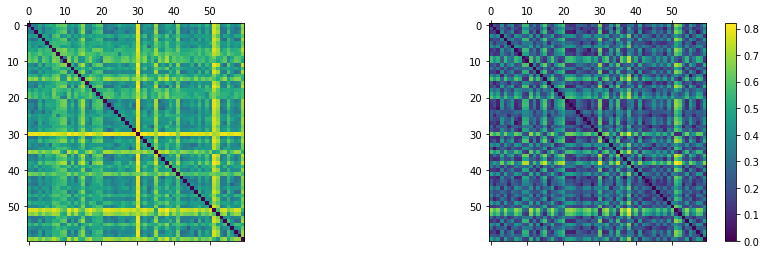

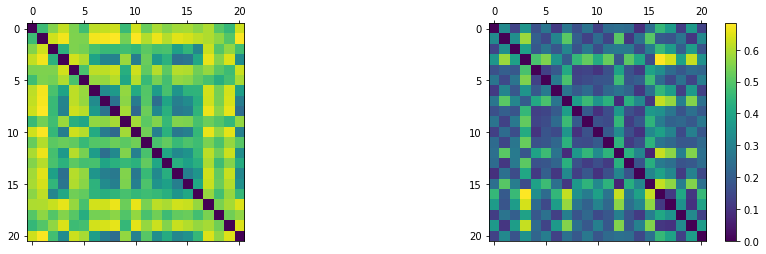

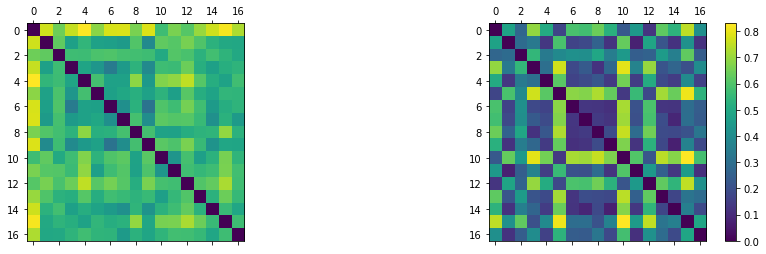

In [31]:
def plotCorrs(y, preds, metric = 'braycurtis'):

    y = y/(np.max(np.max(y)))
    preds = preds / (np.max(np.max(preds)))
    
    sample_dist_measured = squareform(pdist(np.array(y), metric = metric))
    sample_dist_preds = squareform(pdist(preds, metric = metric))
    mantel_res = mantel(sample_dist_preds, sample_dist_measured)
    fig = plt.figure(figsize=(15, 4))
    axarr = fig.subplots(1,2)
    p = axarr[0].matshow(sample_dist_measured)
    #fig.colorbar(p)
    p2 = axarr[1].matshow(sample_dist_preds)
    print(mantel(sample_dist_measured, sample_dist_preds))
    fig.colorbar(p2)
    #Print mantel test metric

def matchTwoDatasets(data1, data2):
    samples = data2.index.values
    data1_matched = data1.loc[samples, :]
    data2_matched = data2.loc[samples, :]
    return(data1_matched, data2_matched)

def plotHeatmap(omic, metric, layer2, direct_filter, prev_filter):
    x_train, x_val, x_test = getXData(prev_filter, omic)
    y_train, y_val, y_test = getYData(direct_filter, omic)
    x_train, y_train = matchTwoDatasets(x_train, y_train)
    x_val, y_val = matchTwoDatasets(x_val, y_val)
    x_test, y_test = matchTwoDatasets(x_test, y_test)
    weight_dir = getWeightDir(omic, metric, layer2, direct_filter, prev_filter)
    file_name = getFileName(weight_dir, '25')
    model = getModel(file_name, metric = metric)
    plotCorrs(y_train, model.predict(x_train))
    plotCorrs(y_val, model.predict(x_val))
    
    y_test = y_test.drop(y_test.index[6], axis = 0)
    x_test = x_test.drop(x_test.index[6], axis = 0)
    plotCorrs(y_test, model.predict(x_test))
    
    
prev_filter = 0.8
direct_filter = True
layer2 = True
metric = "manhattan"
omic = "mtg_metabol/"
plotHeatmap(omic, metric, layer2, direct_filter, prev_filter)

# Compare to mimosa and melonpan

In [27]:
mimosa = pd.read_csv("../../data/metabol/mimosa_predicted_metabolite_table.txt", sep = '\t', index_col = 0)
mimosa = mimosa.T

melonpan = pd.read_csv("../../data/metabol/melonnpan_predicted_metabolite_table.txt", sep = '\t', index_col = 0)
melonpan = melonpan.T

In [28]:
def matchDatasets(y, mimosa, melonpan):
    samples = y.index.values
    samples = samples[[i in mimosa.index.values for i in samples]]
    mimosa_tmp = mimosa.loc[samples, :]
    melonpan_tmp = melonpan.loc[samples, :]
    y = y.loc[samples, :]
    return(y, mimosa_tmp, melonpan_tmp)

y_train, y_val, y_test = getYData(direct_filter, omic)
y_train, mimosa_train, melonpan_train = matchDatasets(y_train, mimosa, melonpan)
y_val, mimosa_val, melonpan_val = matchDatasets(y_val, mimosa, melonpan)
y_test, mimosa_test, melonpan_test = matchDatasets(y_test, mimosa, melonpan)

Number of features MBX:  1267


measured features: 1267
mimosa predicted features: 1551
(0.15588863905940892, 0.031, 59)
(-0.03792536571062662, 0.75, 20)
(0.015415566591369015, 0.929, 17)


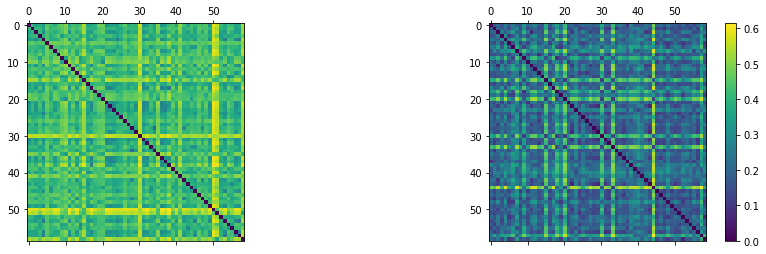

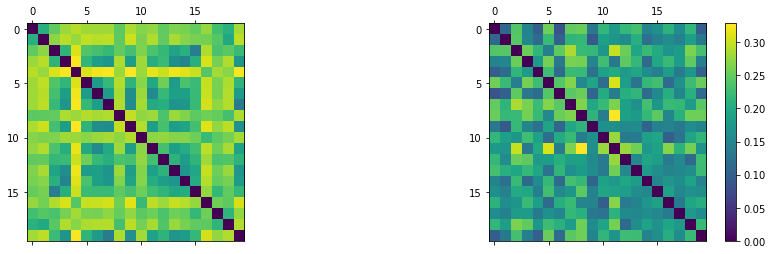

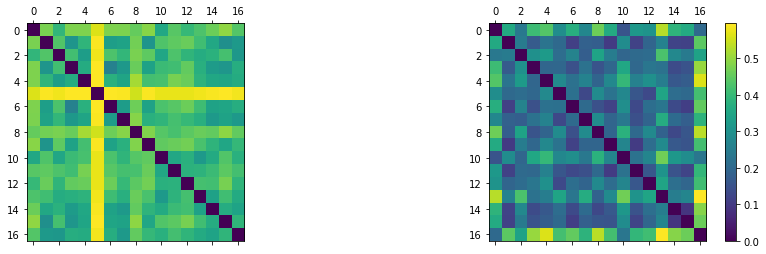

In [29]:
print("measured features: " + str(y_train.shape[1]))
print("mimosa predicted features: " + str(mimosa_train.shape[1]))
plotCorrs(y_train, mimosa_train)
plotCorrs(y_val, mimosa_val)
plotCorrs(y_test, mimosa_test)

measured features: 1267
melonpan predicted features: 211
(0.13428927832324222, 0.012, 59)
(-0.04791981580898906, 0.638, 20)
(-0.027261610146860925, 0.877, 17)


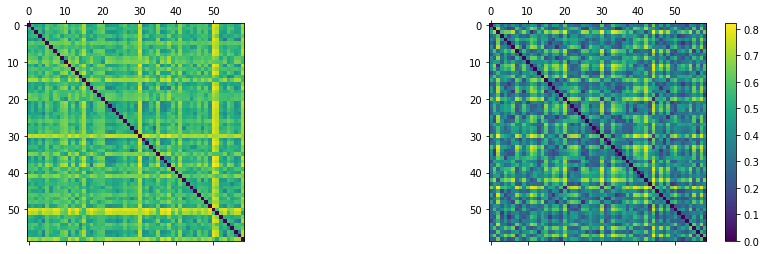

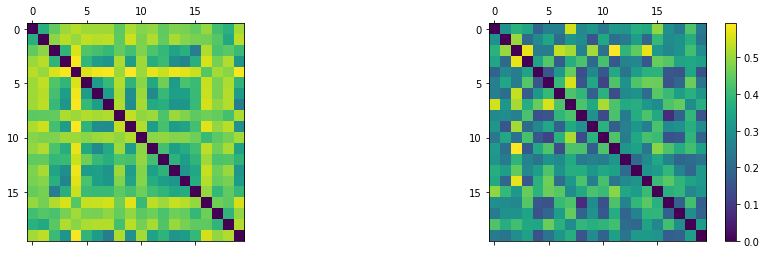

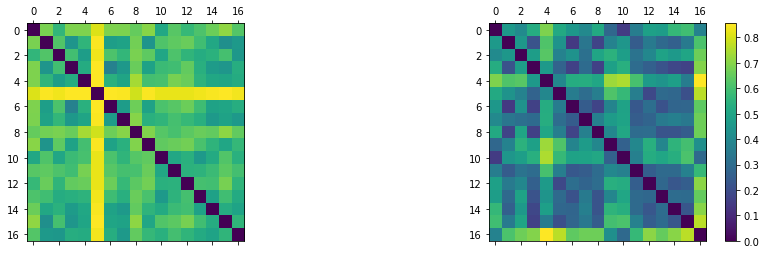

In [30]:
print("measured features: " + str(y_train.shape[1]))
print("melonpan predicted features: " + str(melonpan_train.shape[1]))
plotCorrs(y_train, melonpan_train)
plotCorrs(y_val, melonpan_val)
plotCorrs(y_test, melonpan_test)